##### сеть не удаляет(не блокирует) узел если он перегружен, просто уменьшается нагрузка
##### 
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes False, NumberOfGenerations 150 <br>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\2.57"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    #{"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

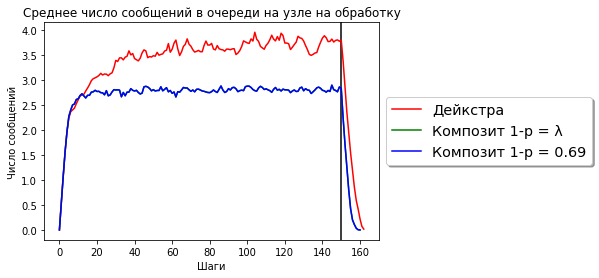

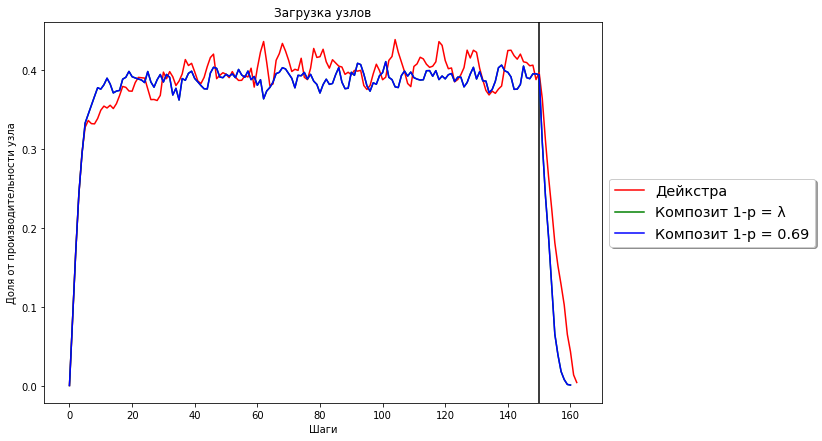

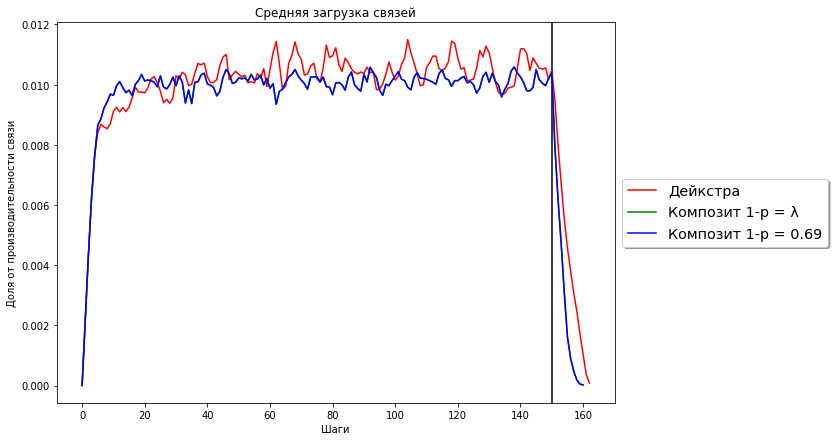

Доставлено 14401 Потеряно 3.9997% -Дейкстра
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = λ
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = 0.69


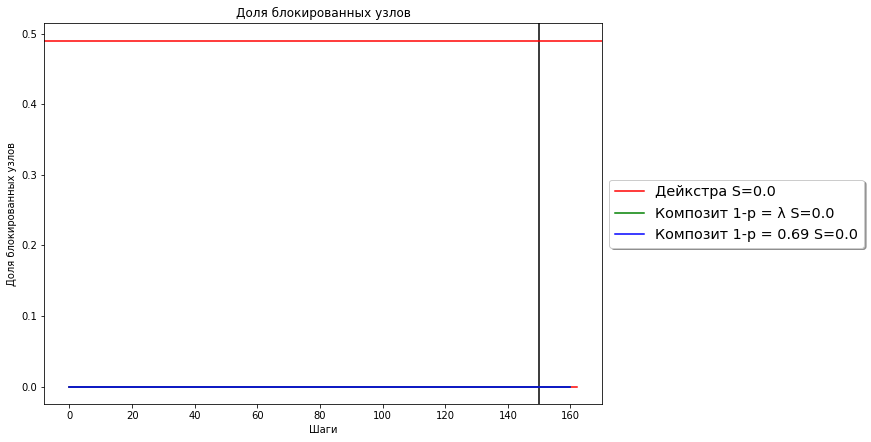

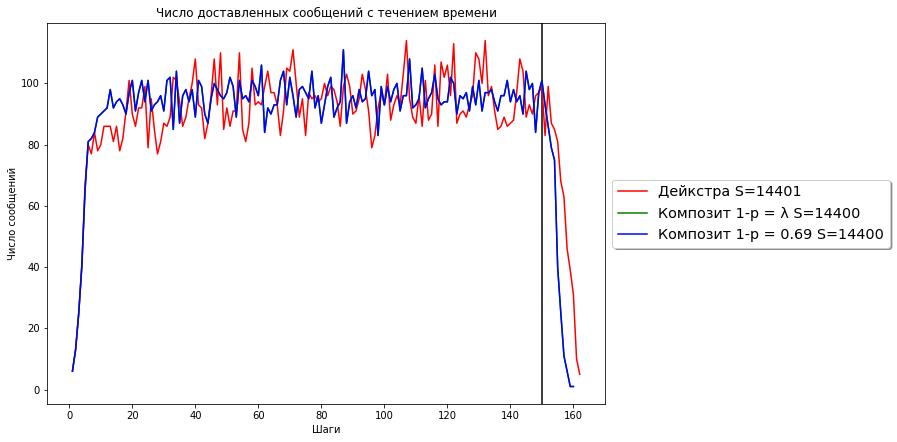

In [2]:
log_tags = [
 {"tag":  "50d0296c-ac78-4568-8a68-b704f50d5d78", "label": "Дейкстра", "color": "red"},
 #{"tag":  "29da792a-26fe-4083-ae51-b99a4d501e24", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "1c845761-52be-4ee5-b85a-dc43df5c8cde", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "ba4a8826-0e22-4879-9ddc-40469d700e0b", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
 
]
quantity = 100;                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

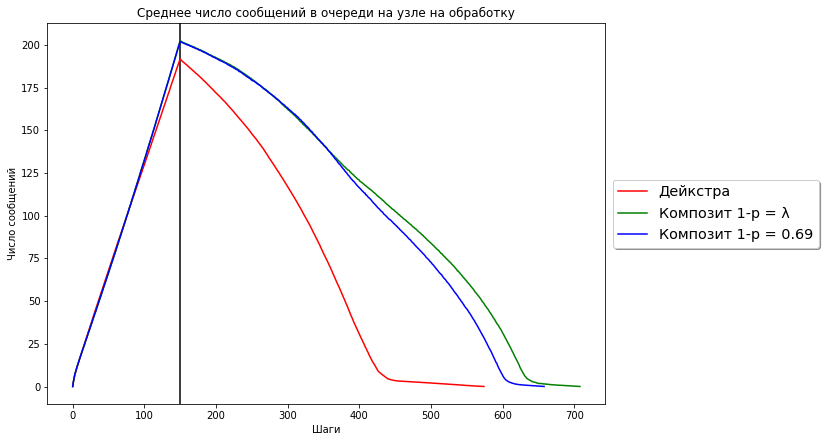

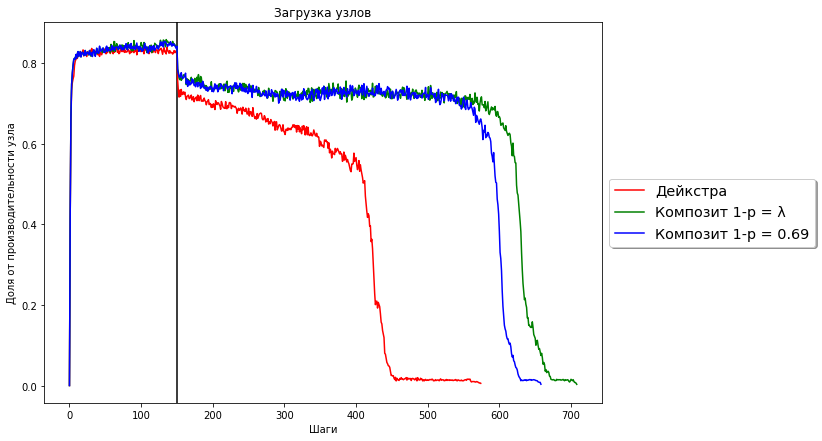

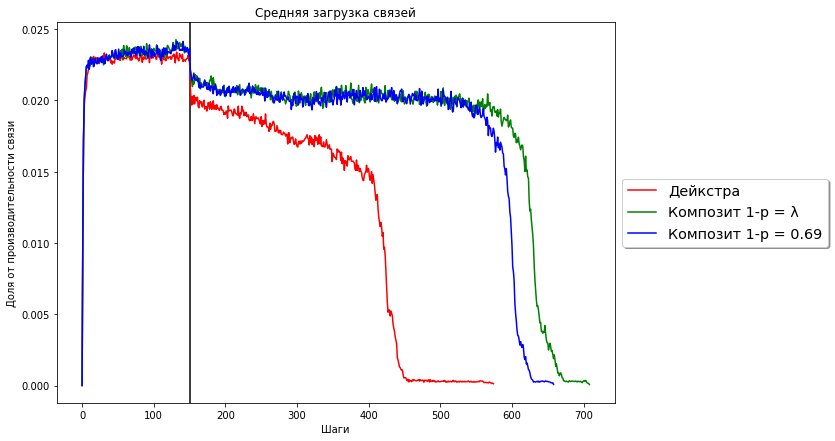

Доставлено 71851 Потеряно 4.1999% -Дейкстра
Доставлено 71850 Потеряно 4.2013% -Композит 1-p = λ
Доставлено 71850 Потеряно 4.2013% -Композит 1-p = 0.69


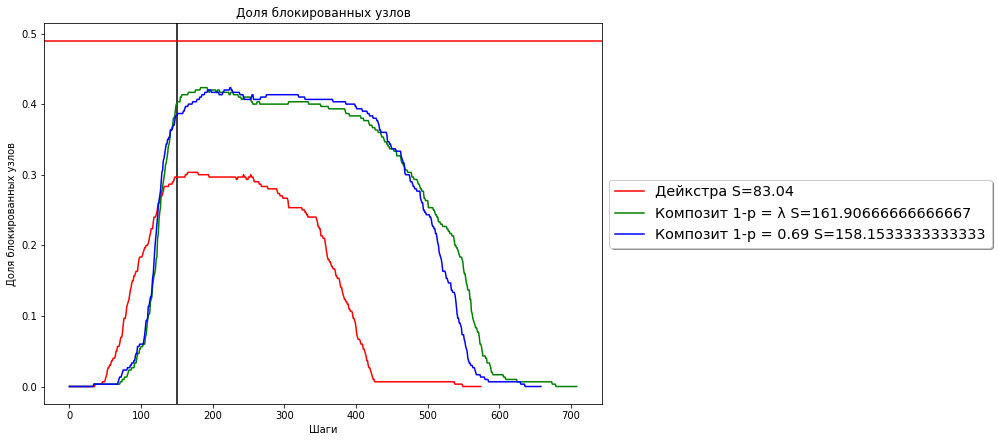

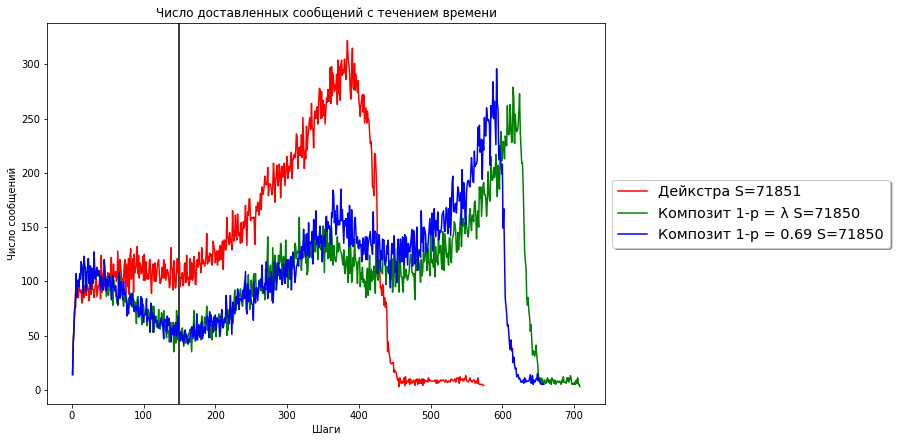

In [3]:
log_tags = [
 {"tag":  "b71ec9c3-b1c0-4028-9614-be37689c38e6", "label": "Дейкстра", "color": "red"},
 #{"tag":  "6087ed64-cc8b-4c1f-8c53-b8f97d107296", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "1b36dccb-fe10-47e9-bbe9-96b8c2de2aee", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "4587d898-7e28-4b40-a573-f757ebac3620", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

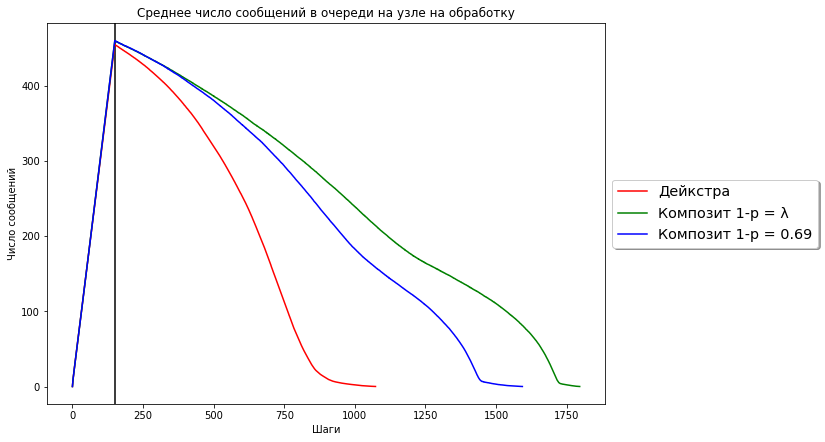

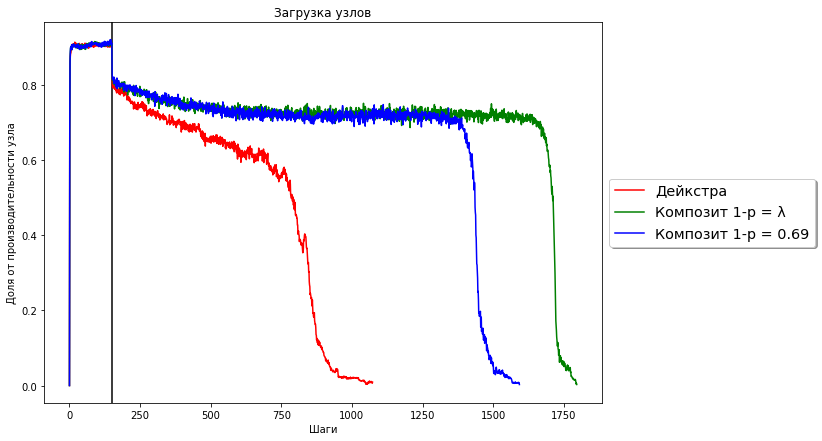

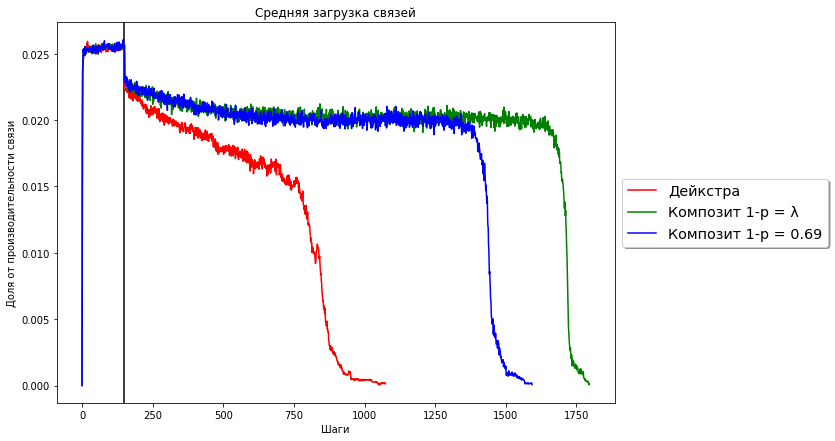

Доставлено 144751 Потеряно 3.5000% -Дейкстра
Доставлено 144750 Потеряно 3.5006% -Композит 1-p = λ
Доставлено 144750 Потеряно 3.5006% -Композит 1-p = 0.69


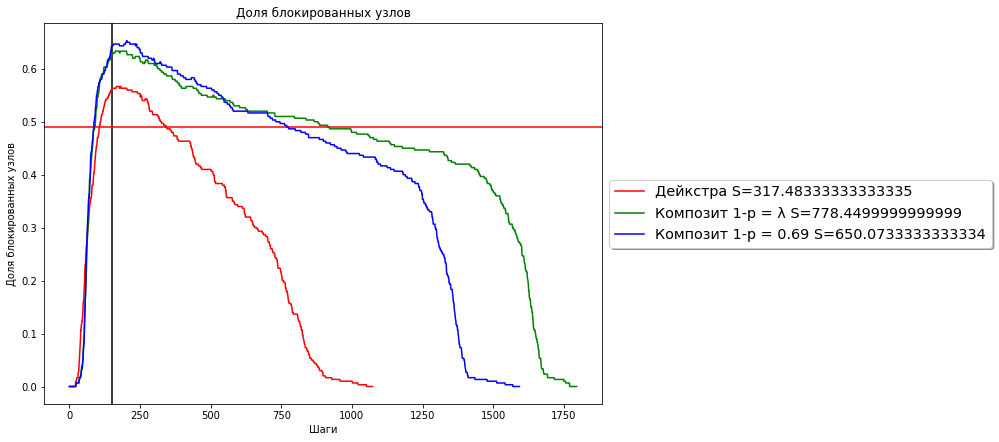

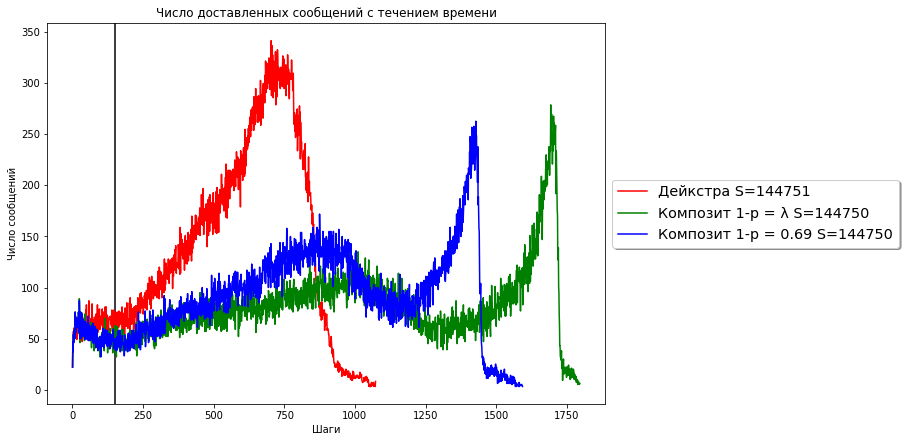

In [4]:
log_tags = [
 {"tag":  "1756847b-bb54-4d81-ad65-9faf25e86fbc", "label": "Дейкстра", "color": "red"},
 #{"tag":  "99d4efce-4b69-4f83-bb16-17c3bf44ad26", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "9124e59e-4677-47cf-8624-754bb2e61c1c", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "f1f3a408-a024-4114-ad37-5361e1078c8d", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

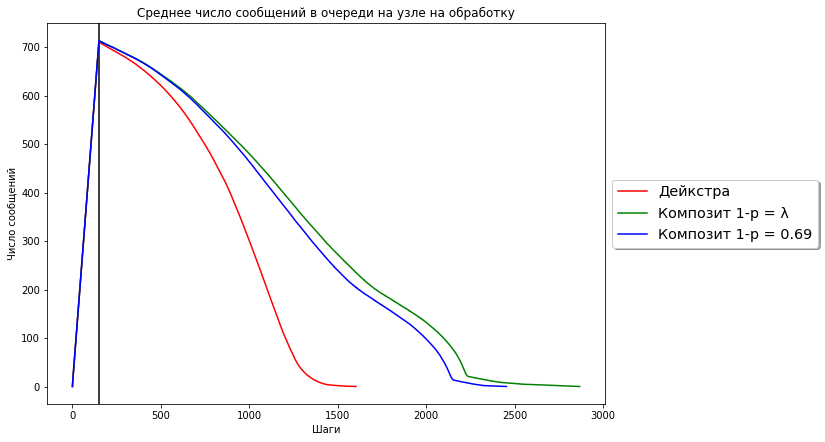

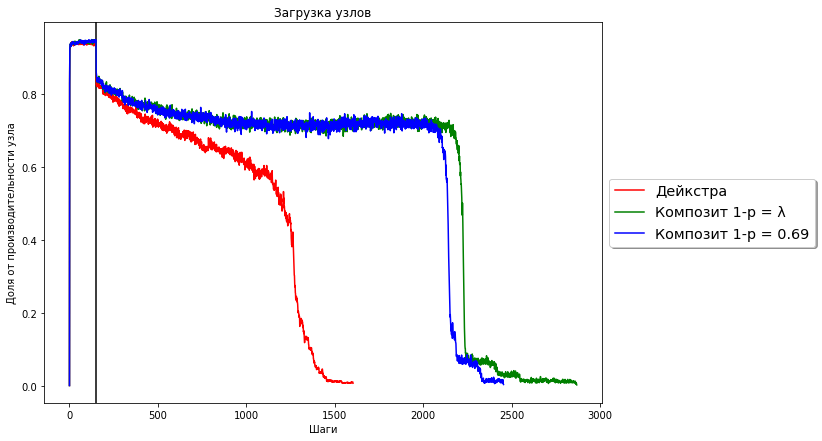

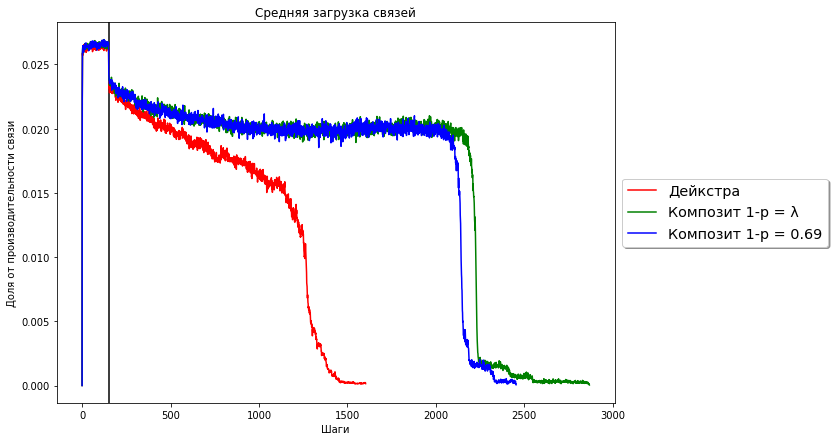

Доставлено 218101 Потеряно 3.0667% -Дейкстра
Доставлено 218100 Потеряно 3.0671% -Композит 1-p = λ
Доставлено 218100 Потеряно 3.0671% -Композит 1-p = 0.69


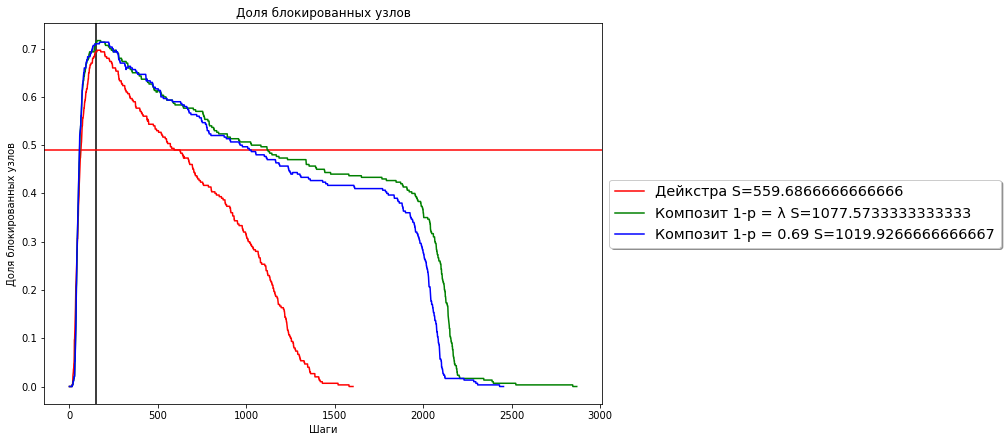

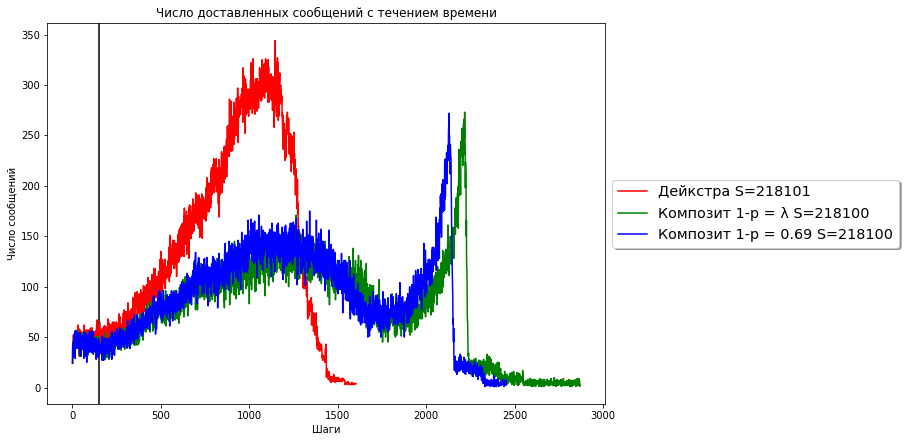

In [5]:
log_tags = [
 {"tag":  "ca89a14f-4ace-4e38-9109-5cbacaa94cd7", "label": "Дейкстра", "color": "red"},
 #{"tag":  "cae1bfe6-7fae-4b04-9460-313128fe6028", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "49f06763-c8e7-445b-9e00-eaf3a0992b1c", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "120e21aa-321b-422d-8b4e-f7cd28165d4a", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 43351 Потеряно 3.6666% -Дейкстра
Доставлено 43350 Потеряно 3.6688% -Композит 1-p = λ
Доставлено 43350 Потеряно 3.6688% -Композит 1-p = 0.69


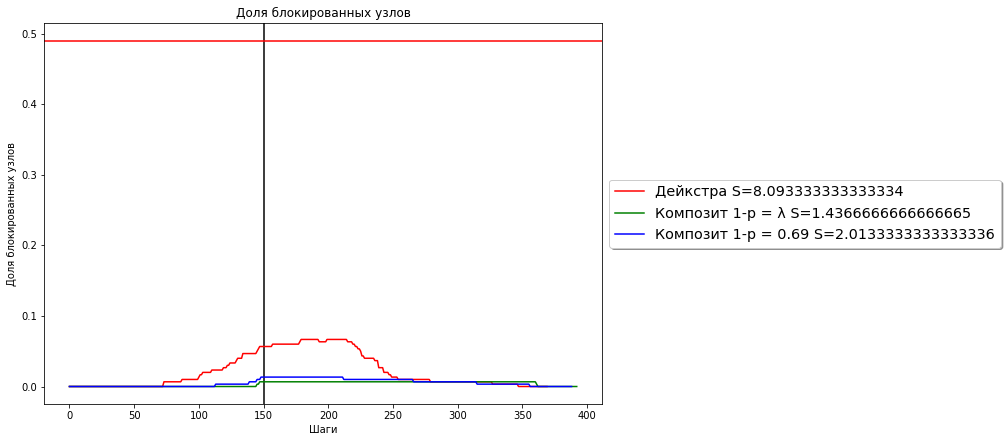

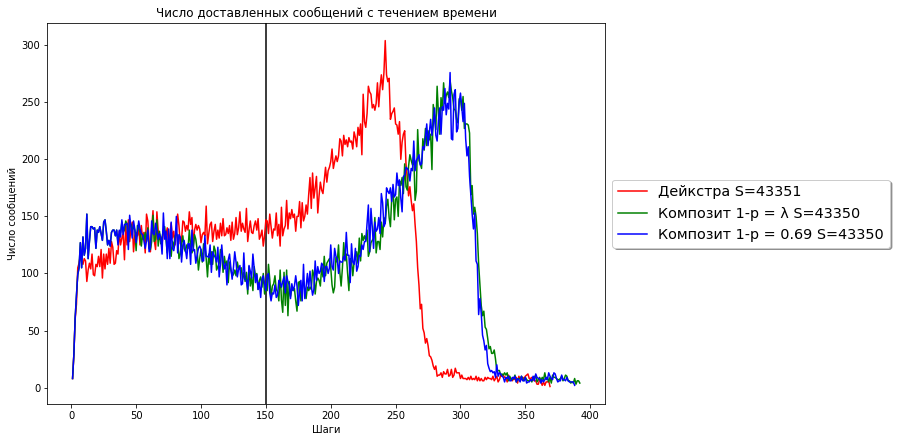

Доставлено 101251 Потеряно 3.5714% -Дейкстра
Доставлено 101250 Потеряно 3.5723% -Композит 1-p = λ
Доставлено 101250 Потеряно 3.5723% -Композит 1-p = 0.69


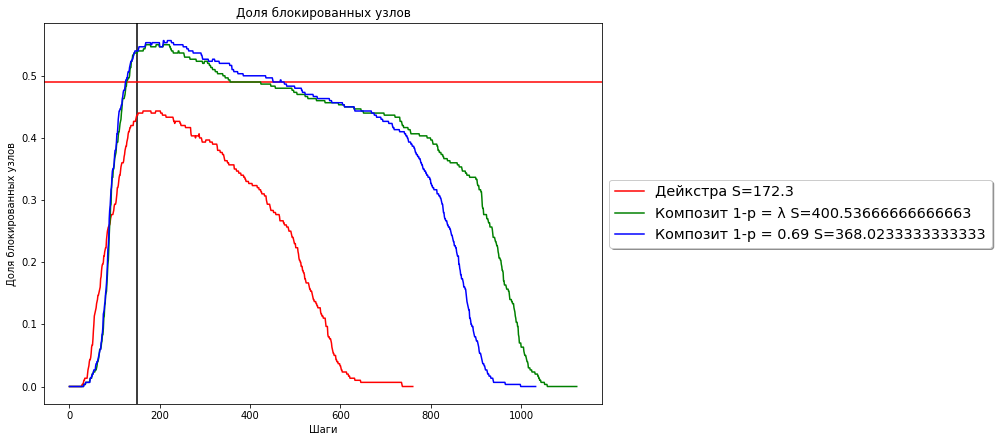

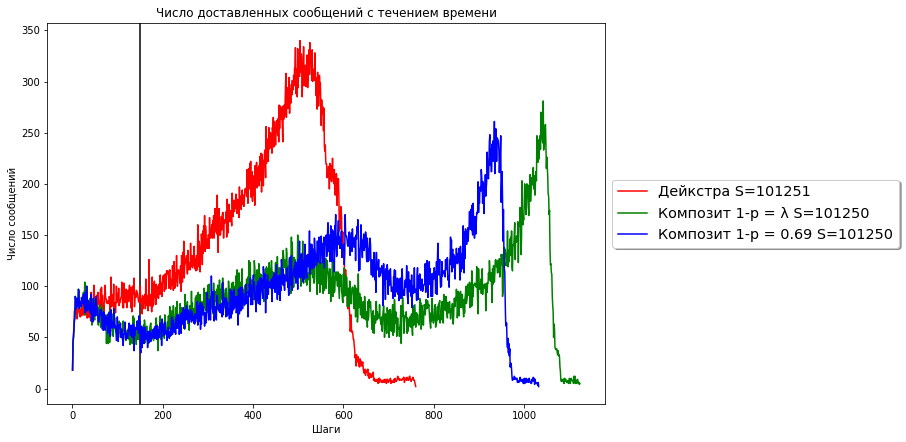

Доставлено 130351 Потеряно 3.4444% -Дейкстра
Доставлено 130350 Потеряно 3.4452% -Композит 1-p = λ
Доставлено 130350 Потеряно 3.4452% -Композит 1-p = 0.69


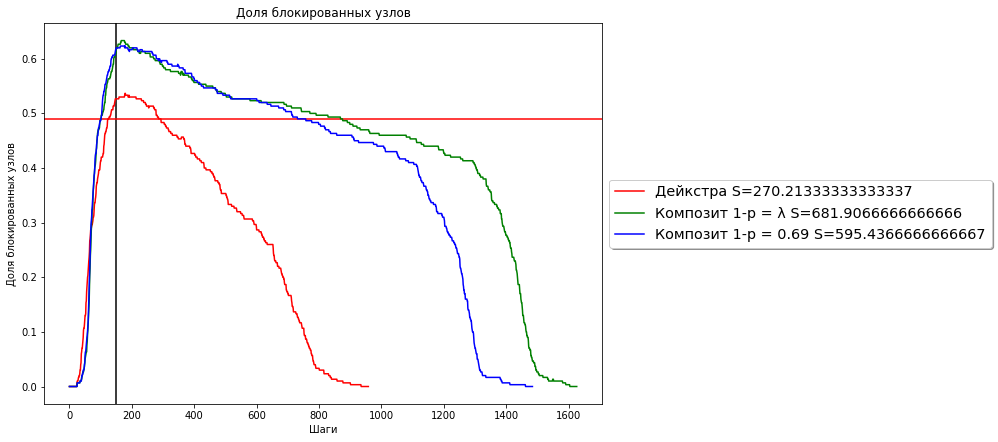

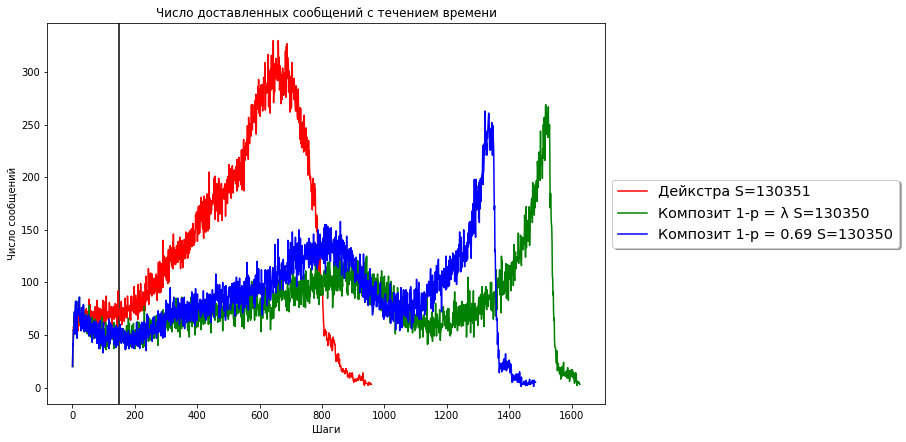

Доставлено 189001 Потеряно 3.0769% -Дейкстра
Доставлено 189000 Потеряно 3.0774% -Композит 1-p = λ
Доставлено 189000 Потеряно 3.0774% -Композит 1-p = 0.69


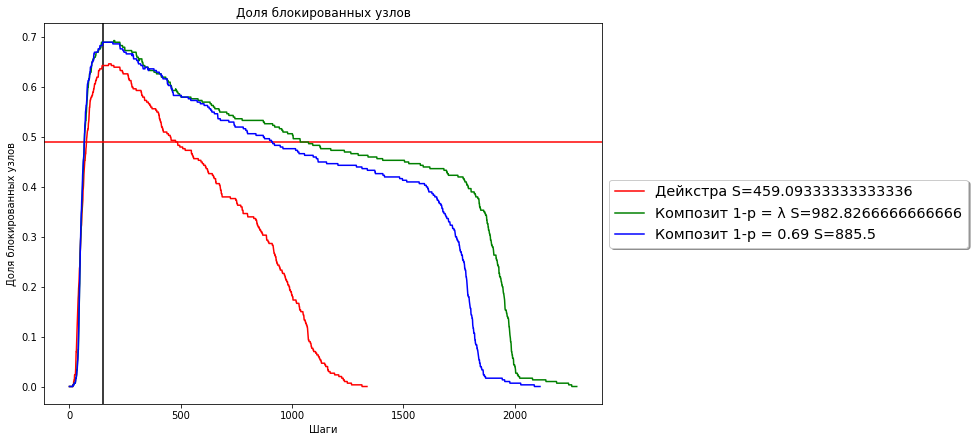

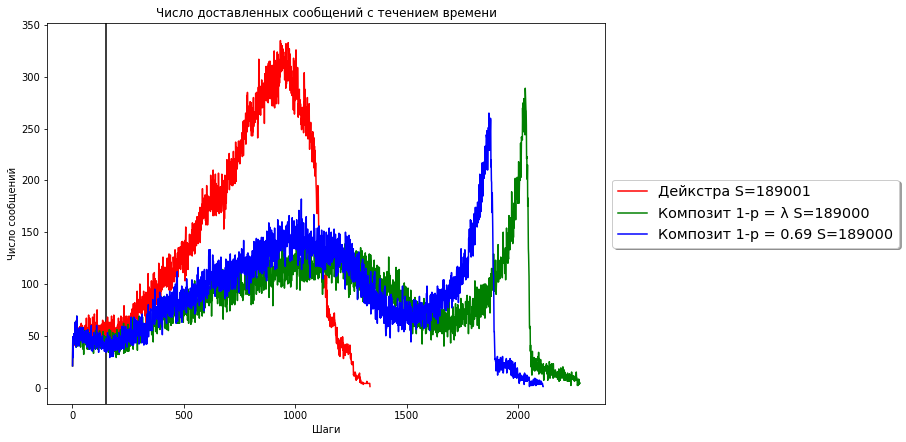

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "5e587ee5-d96d-471d-9cf6-7b13578b3603", "label": "Дейкстра", "color": "red"},
 {"tag":  "8e7e01b7-d1e7-4d3b-9444-60c9752ef2e0", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "7e32f97b-01af-4d2d-94dc-23822e5fac83", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "44a7e617-6197-4a1a-94db-3f55f7b6c461", "label": "Дейкстра", "color": "red"},
 {"tag":  "ab7a0e34-3b84-463a-9605-f102418c1dab", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "8dde5d98-0dcf-4dad-9569-0c08ab619e42", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "e98dab3a-04e4-423e-a2bc-9df5e9a8192f", "label": "Дейкстра", "color": "red"},
 {"tag":  "4683a5d6-729a-4708-ae6b-82c05ba3b898", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "719ba32f-bf68-4f29-8e91-82d5727b7219", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "8938cdf8-6bd2-489a-833e-6924acb72782", "label": "Дейкстра", "color": "red"},
 {"tag":  "50b5d5a7-2ae8-4be0-bfc4-f0845ae6e56a", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "4c92f8d8-eeaa-4f4f-95ee-eda5624f118b", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

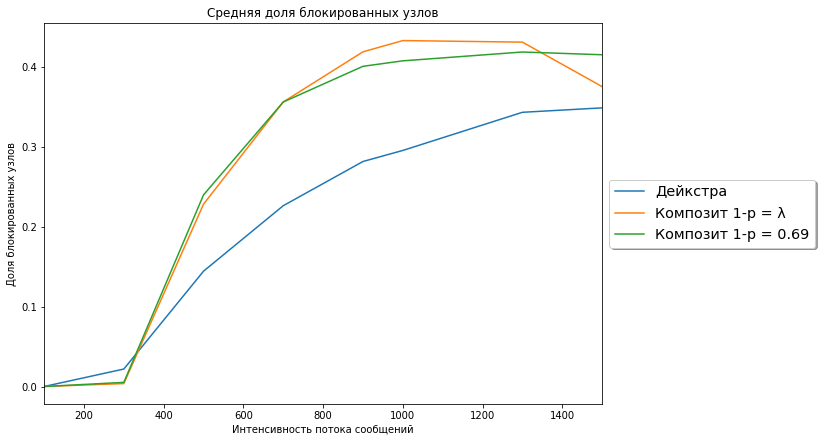

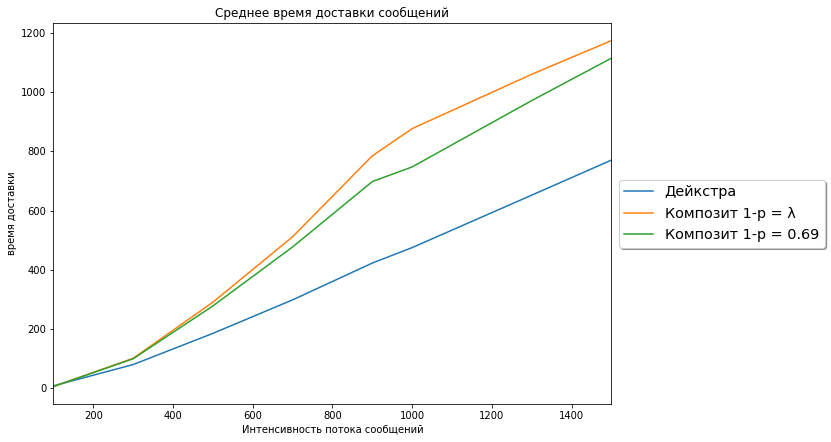

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.207798
Композит 1-p = λ       0.280940
Композит 1-p = 0.69    0.280568

Дейкстра               3.565702
Композит 1-p = λ       3.567394
Композит 1-p = 0.69    3.567394

Дейкстра               361.183282
Композит 1-p = λ       600.527595
Композит 1-p = 0.69    548.874735
